# Binary-Classification with ML Models

## Aim of This Notebook

To classify reviews as positive of negative easily helps company to see negative reviewed products easily without reading too much reviews. So, my focus point is negative rated products. So, I divided my target as 0 and 1. 3 and above rated books were collected together as 1 and 1-2 were classified as 0.

My aim in this notebook is to predict reviews as positive or negative from text. To do this, I used machine learning algoritms. Also, deep learning solutions can be found in same repo. 

### Metric:

As metric, I will use balanced accuracy values, but I will also look to confusion matrix to decide because my concern is to predict 0 (negative) reviews more accurate.

## Importing Necessary Libraries

In [2]:
!pip install mlxtend

You should consider upgrading via the 'c:\users\swammy\anaconda3\python.exe -m pip install --upgrade pip' command.


In [4]:
!pip install xgboost

You should consider upgrading via the 'c:\users\swammy\anaconda3\python.exe -m pip install --upgrade pip' command.


In [6]:
!pip install lightgbm

You should consider upgrading via the 'c:\users\swammy\anaconda3\python.exe -m pip install --upgrade pip' command.


In [7]:
# dataframe and series 
import pandas as pd
import numpy as np

# sklearn imports for modeling part
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from sklearn.model_selection import train_test_split

from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
# To plot
import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

# XGBoost and LGBM classifier imports
import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

In [8]:
pd.options.display.max_columns=100 # To see the hidden columns in dataframe

In [10]:
df = pd.read_csv('sample30.csv', low_memory=False) #taking cleaned data from csv

In [11]:
df.head() 

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,user_sentiment,review_clean
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,2,i love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor. this review was collected as part...,Good,NaN,NaN,2,good flavor this review was collected as part ...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,good flavor.,Good,NaN,NaN,2,good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,i read through the reviews on here before look...,Disappointed,NaN,NaN,0,i read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,my husband bought this gel for us. the gel cau...,Irritation,NaN,NaN,0,my husband bought this gel for us the gel caus...


I have already cleaned my data but after converting my data to new column, I would like to make sure my new column is clean or not.

In [12]:
df.isna().sum()  # to check cleaned column

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     13877
reviews_doRecommend      2404
reviews_rating              0
reviews_text                0
reviews_title               0
reviews_userCity        27881
reviews_userProvince    29642
user_sentiment              0
review_clean                1
dtype: int64

In [13]:
df.dropna(subset=['review_clean'], inplace=True) #droping null's in review clean

In [14]:
df.isna().sum() #to check

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     13877
reviews_doRecommend      2404
reviews_rating              0
reviews_text                0
reviews_title               0
reviews_userCity        27880
reviews_userProvince    29641
user_sentiment              0
review_clean                0
dtype: int64

## Taking Samples for Modeling

My target is highly unbalanced. To teach my model more about minority class, I will take sample data from each classes balanced.

In [17]:
def calc_two_sentiment(reviews_rating):
    '''This function encodes the rating 1 and 2 as 0, others as 1'''
    if reviews_rating >= 3:
        return 1
    else:
        return 0

In [18]:
df['user_sentiment'] = df['reviews_rating'].apply(calc_two_sentiment) # appyling converter to change sentiments from 3 to 2-classed

In [19]:
df['user_sentiment'].value_counts()

1    28025
0     1783
Name: user_sentiment, dtype: int64

In [20]:
df_0 = df.loc[df['user_sentiment']==0].head(50000)

In [21]:
df_1 = df.loc[df['user_sentiment']==1].head(50000)

In [22]:
frames = [df_0, df_1]
#getting together samples
df_sampled = pd.concat(frames)

In [23]:
df_sampled['user_sentiment'].value_counts() #sample classes - balanced chosen

1    28025
0     1783
Name: user_sentiment, dtype: int64

# Modeling Functions

I will use functions for my modeling and spliting parts because I want to get results easily when I changed something in model.

In [25]:
def model_split(df) :
    '''This function splits data to train and test, then vectorized reviews '''
    
    # split train-test
    X_train, X_test, y_train, y_test = train_test_split(df['review_clean'], 
                                                        df['user_sentiment'], test_size=0.2, random_state=42)
    print(X_train.shape)
    print(X_test.shape)
        
    # define vectorize and fit to data     
    word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

    word_vectorizer.fit(df['review_clean'])
    
    # train - test vectorized features - tranforming to suitable format for modeling
    train_word_features = word_vectorizer.transform(X_train) 
    test_word_features = word_vectorizer.transform(X_test)
    
    return train_word_features , test_word_features, y_train, y_test 

def model(df,classifier):
    '''this function gives modeling results and confusion matrix also'''
    train_word_features,test_word_features,y_train,y_test = model_split(df)
    classifier.fit(train_word_features, y_train)
    
    # calculating results 
    y_pred_train = classifier.predict(train_word_features)
    y_pred = classifier.predict(test_word_features)
    
    #for smart printing (learned from our lead instructor Bryan Arnold)
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {accuracy_score(y_test, y_pred)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred_train)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred)}")
    

In [26]:
# choosing classifier and running model
classifier = LogisticRegression(class_weight = "balanced", C=0.5, solver='sag')
model(df_sampled,classifier)

(23846,)
(5962,)
Accuracy:
TRAIN: 0.9537029271156588
TEST: 0.943139885944314

Balanced Accuracy:
TRAIN: 0.9618165729065065
TEST: 0.889112221532667


With simple Logreg, I got my baseline model for 2-balanced class data. I do not work on too much this model, because it is my baseline. I will decide after other models. My main concern is this matrix are wrong predictions on 0. I will try to find the best results according to accuracy and true 0 class predictions. 

### One More Check to See roc-auc Score with Cross-Val

In [27]:
# vectorize data for calculation
word_vectorizer = TfidfVectorizer(sublinear_tf=True,strip_accents='unicode',
        analyzer='word',token_pattern=r'\w{1,}',stop_words='english',
        ngram_range=(1, 1),max_features=10000)

word_vectorizer.fit(df_sampled['review_clean'])
    
word_features = word_vectorizer.transform(df_sampled['review_clean'])

scores = cross_val_score(classifier, word_features, df_sampled['user_sentiment'], cv=3, scoring='roc_auc')
print(scores.mean(), "+/-", scores.std())

0.9277745442741944 +/- 0.04463079731926346


I have pretty good results for baseline.

# Decision Tree Classifier

Decision tree classifier is a supervised classification technique which splits data according to certain parameters continuously.

In [28]:
des_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=5, 
                                        random_state=42, class_weight='balanced')
model(df_sampled,des_tree)

(23846,)
(5962,)
Accuracy:
TRAIN: 0.9606223265956555
TEST: 0.961590070446159

Balanced Accuracy:
TRAIN: 0.7070450831962745
TEST: 0.6933852639688416


I do not find better results than baseline when I try to tune this model, so I continue to try other models. With simple Logreg, my test accuracy was 87, but this one gives 0.69.

# Extra-Trees Classifier

Extra Trees works like a Random Forest. It builds multiple trees and splits nodes using random subsets of features. There are two main differences it does not samples without replacement, and nodes are split on random splits, not best splits. I also used different parameters and tuned them manually.

In [29]:
rf_extra = ExtraTreesClassifier(max_depth=5, criterion= 'entropy', min_samples_leaf=3, min_samples_split=18, 
                          random_state=42, n_estimators = 100, class_weight='balanced', n_jobs = -1)

model(df_sampled,rf_extra)

(23846,)
(5962,)
Accuracy:
TRAIN: 0.9332802147110627
TEST: 0.9315665883931566

Balanced Accuracy:
TRAIN: 0.8300947880060237
TEST: 0.8135408418754949


I got better than decision tree but not better than baseline.

# Random Forest Classifier

Random forest models can reduce overfitting risk by randomness as building n_estimators, bootstrapping sample and splitting nodes on the best split among a random subset of the features selected at every node and converting non-homogeneous node into best possibles.

In [30]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1,class_weight='balanced',
                            criterion = 'entropy',max_features = 'sqrt',min_samples_split = 5)
model(df_sampled,rf)

(23846,)
(5962,)
Accuracy:
TRAIN: 0.9997064497190304
TEST: 0.972660181147266

Balanced Accuracy:
TRAIN: 0.999843715114981
TEST: 0.7658557854865287


Random forest give high accuracy but it is overfit. It could not split my target well. I can find best parameters for my model and tune it with grid search. But, it took too much time, so I prefered to changed parameters manually and run for each time. I got the best results with this parameters. There is grid search code below to show how to find best parameters and best score.

In [32]:
 grid_p = {"n_estimators": [20, 50, 100],
           "criterion": ["gini", "entropy"],
           "max_features": ['sqrt', 'log2'],
           "min_samples_split": [2, 5, 10]}

 grid_search = GridSearchCV(rf, grid_p, n_jobs=-1, cv=3, scoring='roc_auc')
 grid_search.fit(word_features, df_sampled['user_sentiment'])

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              criterion='entropy',
                                              max_features='sqrt',
                                              min_samples_split=5, n_jobs=-1,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [20, 50, 100]},
             scoring='roc_auc')

In [33]:
grid_search.best_score_

0.9132323733319669

In [34]:
best_rf = grid_search.best_estimator_

# XGBoost Classifier

XGBoost is an efficient and flexiable classifier which implements models with Gradient Boosting. Although, it is very usefull classifier, it can be overfit easily. So, parameter selection is very imporant for XGBoost. I can do grid search also for XGBoost to tune our parameters but it takes too much time. So, I played around our parameters manually and decided the best one.

In [35]:
xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx',
                      num_class = 3, maximize = False, eval_metric = 'merror',early_stopping_rounds=10,
                        eta = .1,max_depth = 12, colsample_bytree = .4, learning_rate = 0.1,
                        max_delta_step=1)
model(df_sampled, xgb)

(23846,)
(5962,)


C:\Users\swammy\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stopping_rounds", "maximize", "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:
TRAIN: 0.9854063574603708
TEST: 0.9721569942972157

Balanced Accuracy:
TRAIN: 0.8800827015851137
TEST: 0.7627549273470435


It gives good results but not better than baseline. The most important parameters are learning rate, early stopping round, max_depth and max_delta step for my tuning. When I changed them, results significantly changed. So, I set this parameters according to results which I found.

# LGBM Classifier

LGBM also constructs a gradient boosting model. It has some advantages that faster training speed and higher efficiency with lower memory usage. It is capable large data sets with significantly quicker than XGBoost. So, I tried this one also.

In [36]:
lgbm = LGBMClassifier(booster = 'gbtree', nrounds = 'min.error.idx', maximize = False,eta = .1,max_depth = 10, 
                      colsample_bytree = .4,learning_rate = 0.1,max_delta_step=1)
model(df_sampled, lgbm)

(23846,)
(5962,)
[LightGBM] [Warning] Unknown parameter: booster
[LightGBM] [Warning] Unknown parameter: nrounds
[LightGBM] [Warning] Unknown parameter: maximize
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
Accuracy:
TRAIN: 0.9736643462215885
TEST: 0.9706474337470647

Balanced Accuracy:
TRAIN: 0.7916541070981526
TEST: 0.7520351387789167


It gives higher than 80% but lower than baseline.

In [37]:
# to keep results and see in dataframe
df_results = pd.DataFrame(columns=["Model", 'train_balanced', 'test_balanced']) # to see all results

In [38]:
df_results = df_results.append({       # writing results to df
     "Model": 'Logreg' ,
               'train_balanced' : 0.96,
                    'test_balanced' : 0.88}, ignore_index=True)
df_results = df_results.append({       # writing results to df
     "Model": 'Decision Tree' ,
               'train_balanced' : 0.96,
                    'test_balanced' : 0.88}, ignore_index=True)
df_results = df_results.append({       # writing results to df
     "Model": 'Extra-Tree' ,
               'train_balanced' : 0.83,
                    'test_balanced' : 0.81}, ignore_index=True)
df_results = df_results.append({       # writing results to df
     "Model": 'Random Forest' ,
               'train_balanced' : 0.99,
                    'test_balanced' : 0.76}, ignore_index=True)
df_results = df_results.append({       # writing results to df
     "Model": 'XGBM' ,
               'train_balanced' : 0.88,
                    'test_balanced' : 0.76}, ignore_index=True)
df_results = df_results.append({       # writing results to df
     "Model": 'LGBM' ,
               'train_balanced' : 0.79,
                    'test_balanced' : 0.75}, ignore_index=True)


In [39]:
df_results

,Model,train_balanced,test_balanced
0,Logreg,0.96,0.88
1,Decision Tree,0.96,0.88
2,Extra-Tree,0.83,0.81
3,Random Forest,0.99,0.76
4,XGBM,0.88,0.76
5,LGBM,0.79,0.75


According to results, my baseline did better than others. I can work on to tune these models and can get better results. But, I would like to try and see how deep learning models will do. So, I drop it here and continue to model with NN.

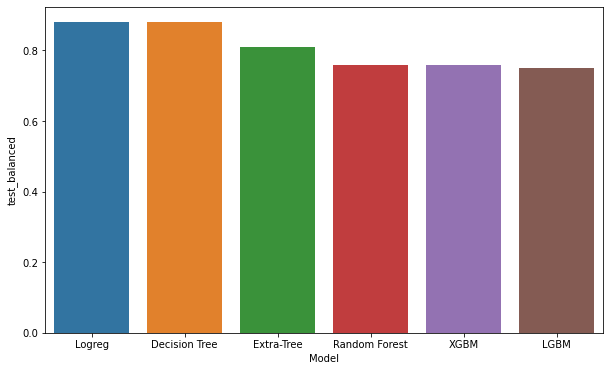

In [40]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='Model', y= 'test_balanced',data=df_results)

# Feature Improvements for This Notebook

If I will not get good results with deep learning, the ideas below can be tried; 
- Gradient boost models can be tuned.
- Grid search can be done.
- I can come back to text column and do deeper analysis and cleaning and feature engineering.